## Frameworks

In [1]:
import gurobipy as gp
from gurobipy import GRB
import json
import numpy as np
import pandas as pd
import time

## 1) Load Instance

In [2]:
start = time.time()

In [3]:
#path="instances/test.json"
path="instances/toy_instance.json"
#path="instances/medium_instance.json"
#path="instances/large_instance.json"

# JSON file
f = open (path, "r")
  
# Reading from file
data = json.loads(f.read())

In [4]:
# Gains
Gm=[]
for job in data["jobs"]:
    Gm.append(job['gain'])
Gm=np.array(Gm)

# Penalty
Pm=[]
for job in data["jobs"]:
    Pm.append(job['daily_penalty'])
Pm=np.array(Pm)

# Due Date
Dm=[]
for job in data["jobs"]:
    Dm.append(job['due_date'])
Dm=np.array(Dm)

# Penalty per day
Penalty=[]
for job in data["jobs"]:
    job_penalty=[]
    p=0
    for t in range(data["horizon"]):
        if (t>job["due_date"]-1):
            p+=job["daily_penalty"]
        job_penalty.append(p)
    Penalty.append(job_penalty)
Penalty=np.array(Penalty)

# Profit per day
Profit=[]
for job in data["jobs"]:
    job_benef=[]
    p=job['gain']
    for t in range(data["horizon"]):
        if (t>job["due_date"]-1):
            p-=job["daily_penalty"]
        job_benef.append(p)
    Profit.append(job_benef)
Profit=np.array(Profit)

# Vacations per day and per employee
Vacations=[]
for e in data["staff"]:
    e_planning=[]
    v=e['vacations']
    for t in range(data["horizon"]):
        if (t+1 in v):
            e_planning.append(1)
        else:
            e_planning.append(0)
    Vacations.append(e_planning)
Vacations=np.array(Vacations)

# Employee qualifications
Qualifications_staff=[]
for staff in data["staff"]:
    list_staff=[]
    for q in data["qualifications"]:
        if(q in staff["qualifications"]):
            list_staff.append(1)
        else:
            list_staff.append(0)
    Qualifications_staff.append(list_staff)
Qualifications_staff = np.array(Qualifications_staff)

# Jobs Qualifications
Qualifications_job=[]
for job in data["jobs"]:
    #working_days_per_qualification
    list_job=[]
    for q in data["qualifications"]:
        try:
            val=job['working_days_per_qualification'][q]
        except:
            val=0
        list_job.append(val)
    Qualifications_job.append(list_job)
Qualifications_job=np.array(Qualifications_job)

## 2) Model

In [5]:
###
# MODEL
model = gp.Model()

horizon=data["horizon"]
qualifs=len(data["qualifications"])
projects=len(data["jobs"])
staffs=len(data["staff"])

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-29


## 3) Variables

In [6]:
###
# VARIABLES

# Planning 
Planning = model.addMVar(
                        shape=(staffs,horizon,projects,qualifs),
                        vtype=GRB.BINARY,
                        name="Planning"
                        )

# Delay 
Delay_project = model.addVars(
                                projects,
                                lb=0,
                                ub=horizon,
                                vtype=GRB.INTEGER,
                                name="Delay_project"
                            ) 

# End Date 
End_project = model.addVars(
                                projects,
                                lb=1,
                                ub=horizon,
                                vtype=GRB.INTEGER,
                                name="End_project"
                            ) 

# Realisation Boolean
Realisation = model.addVars(
                                projects,
                                vtype=GRB.BINARY,
                                name="Realisation"
                            )

# Begin 

Begin_project = model.addVars(
                                projects,
                                lb=1,
                                ub=horizon,
                                vtype=GRB.INTEGER,
                                name="End_project"
                            ) 

## 4) Constraints

In [7]:
###
# CONSTRAINTS

#1 Uicity of affectation 
model.addConstrs(
    (gp.quicksum(gp.quicksum(Planning[staff][t]))<= 1
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
    ),
    name="staff_qualif_unicity"
) 

#2 Vacations
model.addConstrs(
    (Planning[staff][t][job][qualif]<=1-Vacations[staff][t] 
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
    ),
    name="Vacations_constraint"
) 


#3 Qualification staff
model.addConstrs(
    (Planning[staff][t][job][qualif]<=Qualifications_staff[staff][qualif]
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
    ),
    name="Qualif_staff_constraint"
) 


# Definition d'une liste de la somme des temps de qualifs par projet
Max_temp_qualif_job=[]
for job in range(len(data["jobs"])):
    l_job=[]
    for qualif in range(len(data["qualifications"])):
        temp_qualif_job=0
        for t in range(data["horizon"]):
            for staff in range(len(data["staff"])):
                temp_qualif_job+=Planning[staff][t][job][qualif]
        l_job.append(temp_qualif_job)
    Max_temp_qualif_job.append(l_job)
Max_temp_qualif_job


#4 Couverture des qualifs => realisation
model.addConstrs(
        (Max_temp_qualif_job[job][qualif] >= Realisation[job] *  Qualifications_job[job][qualif]
            for job in range(len(data["jobs"]))
            for qualif in range(len(data["qualifications"]))
        ), name = "cover_qualif"
)

#5 Unicity realisation
model.addConstrs(
    (Max_temp_qualif_job[job][qualif] <= Qualifications_job[job][qualif]
            for job in range(len(data["jobs"]))
            for qualif in range(len(data["qualifications"]))
), name = "project_done_once")

#6 end project 
model.addConstrs(
   (Planning[staff][t][job][qualif] * t+1 <= End_project[job]
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
), name = "end_project_date")

#7 Delay 
model.addConstrs(
    (End_project[job] - Dm[job] <= Delay_project[job]
       for job in range(len(data["jobs"]))
    ), name="delay_project"
)

#8 Begin Date to compute Z3
print("#8 Begin Date to compute Z3")


#9 Don't begin a project that is not done
print("#9 Don't begin a project that is not done")



Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
#8 Begin Date to compute Z3
#9 Don't begin a project that is not done


## 5) Objectives

In [8]:
model.ModelSense = GRB.MAXIMIZE

### Z1: Maximize Profit

In [9]:
# Objectif Unique : 
# Z1 = gp.quicksum(Realisation.values()*(Gm-Pm*Delay_project.values()))
# model.setObjective(Z1,GRB.MAXIMIZE)

In [10]:
# ici on suppose que si le projet n'est pas réalisé alors il n'est pas commencé donc pas de delay ?
# à vérifier ! (ajouter constraint #9 ?)

Z1 = gp.quicksum((Realisation.values()*Gm)-(Pm*Delay_project.values()))

In [11]:
model.setObjectiveN(
    Z1, 
    index=0, 
    priority=3, 
    name='Profit', 
    weight=1)

### Z2: Minimize Number of Projects per Employee

In [12]:
Include_Z2 = True

In [13]:
# Jobs done by one staff
jobs_staffeur = model.addMVar(shape=(staffs,projects),vtype=GRB.BINARY,name="jobs_staffeur")

for staff in range(staffs):
    for job in range(projects):
        val=[]
        for t in range(horizon):
            for qualif in range(qualifs):
                val.append(Planning[staff][t][job][qualif])
        #real_jobs_staffeur[staff][job]=max(val)
        model.addConstr((jobs_staffeur[staff][job] == gp.max_(val)))

# Sum of all jobs for one staff
sum_staff_jobs = model.addVars(staffs,vtype=GRB.INTEGER, name="sum_staff_jobs")         

for staff in range(staffs):
    model.addConstr((sum_staff_jobs[staff]==gp.quicksum(jobs_staffeur[staff])))


In [14]:
if Include_Z2:
    for staff in range(staffs):
        model.setObjectiveN(sum_staff_jobs[staff], 
                            index=1+staff, 
                            priority=2, 
                            weight=-1)  #weight = -1 to minimize


### Z3: Minimize Realisation Time

In [15]:
Include_Z3 = False

In [16]:
days_project = model.addMVar((projects,horizon), vtype=gp.GRB.INTEGER)

## création d'une liste pour chaque jour met soit 0 si le projet n'est pas travaillé soit le jour en question
## l'idée est d'ensuite récupérer le min de cette liste
for job in range(projects):
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                                                    #>= (1 ou 0) * le jour =>si le jour 2 est travaillé on aura 2
                model.addConstr(days_project[job][t] >= Planning[staff][t][job][qualif]*(t+1))

## Je suis en train d'essayer de dire que Begin_project est le minimum de la liste précédemment construite 
"""Begin_project = model.addVars(projects, lb=1, ub=horizon, vtype=gp.GRB.INTEGER)

for job in range(projects):
    print(gp.min_(days_project[job]))
    print(Begin_project[job])
    model.addConstr(Begin_project[job] == gp.min_(days_project[job]))"""


'Begin_project = model.addVars(projects, lb=1, ub=horizon, vtype=gp.GRB.INTEGER)\n\nfor job in range(projects):\n    print(gp.min_(days_project[job]))\n    print(Begin_project[job])\n    model.addConstr(Begin_project[job] == gp.min_(days_project[job]))'

In [17]:
"""Begin_project = model.addVars(projects, lb=0, ub=horizon, vtype=gp.GRB.INTEGER)

for job in range(projects):
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                model.addConstr(Begin_project[job] >= Planning[staff][t][job][qualif]*t+1)"""

'Begin_project = model.addVars(projects, lb=0, ub=horizon, vtype=gp.GRB.INTEGER)\n\nfor job in range(projects):\n    for t in range(horizon):\n        for staff in range(staffs):\n            for qualif in range(qualifs):\n                model.addConstr(Begin_project[job] >= Planning[staff][t][job][qualif]*t+1)'

In [18]:
if Include_Z3:
    for job in range(projects):
        model.setObjectiveN((End_project[job]-Begin_project[job]) , 
                            index=1+job, 
                            priority=3, 
                            weight=-1)  #weight = -1 to minimize

## 6) Optimize

In [19]:
# epsilon

In [20]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 953 rows, 288 columns and 2018 nonzeros
Model fingerprint: 0x0f3d3498
Model has 15 general constraints
Variable types: 0 continuous, 288 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 5e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives (2 combined) ...
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 733 rows and 140 columns
Presolve time: 0.01s
Presolved: 220 rows a

## 7) Results

In [21]:
end = time.time()
print("Time taken: ", round(end - start,2), "seconds")
print("Time taken: ", round((end - start)/60,2), "minutes")
# toy : 1s
# medium : 53s
#large : 3,7 min

Time taken:  1.9 seconds
Time taken:  0.03 minutes


### Objectives

In [22]:
# Z1
print("Z1: Maximize Profit\n")
print("Solution || Best ")
print(" ",model.objVal,"  || ",Gm.sum())
#print("Solution Profit : ",model.objVal,"\nBest Profit     : ",Gm.sum())

Z1: Maximize Profit

Solution || Best 
  65.0   ||  80


In [23]:
# Z2
print("Z2: Minimize Number of Projects per Employee\n")
print("staff || job(s)")
for i in range(len(data["staff"])):
    print(" ",i,"  || ",sum_staff_jobs[i].x)
    #print("staff",i,":",sum_staff_jobs[i].x,"job")

Z2: Minimize Number of Projects per Employee

staff || job(s)
  0   ||  2.0
  1   ||  2.0
  2   ||  2.0


In [24]:
# Z3
print("Z3: Minimize Realisation Time\n")
print("Project || Begin ||  End  || Delta")
for i in range(len(data["jobs"])):
    print(i,"      || ",Begin_project[i].x," || ",End_project[i].x," || ",End_project[i].x-Begin_project[i].x)
    #print("project",i,"|| begin:",Begin_project[i].x,"-end:",End_project[i].x,"|| delta:",End_project[i].x-Begin_project[i].x)
    

Z3: Minimize Realisation Time

Project || Begin ||  End  || Delta
0       ||  1.0  ||  3.0  ||  2.0
1       ||  1.0  ||  3.0  ||  2.0
2       ||  1.0  ||  4.0  ||  3.0
3       ||  1.0  ||  3.0  ||  2.0
4       ||  1.0  ||  5.0  ||  4.0


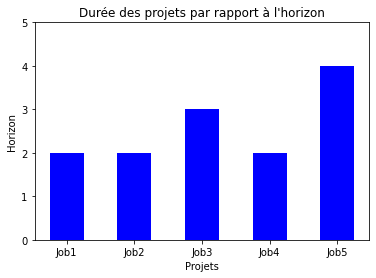

In [25]:
import matplotlib.pyplot as plt

projects_duration = [End_project[i].x-Begin_project[i].x for i in range(len(data["jobs"]))]
projects_names = [job["name"] for job in data["jobs"]]

plt.bar(projects_names, projects_duration, color='blue', width=0.5)

plt.ylim(0, horizon)

plt.xlabel('Projets')
plt.ylabel('Horizon')

plt.title('Durée des projets par rapport à l\'horizon')

plt.show()


In [61]:
qualif_per_job = {staff:[] for staff in range(staffs)}

for staff in range(staffs):
    for t in range(horizon):
        for qualif in range(qualifs):
            for job in range(len(data["jobs"])):
                if(int(Planning[staff][t][job][qualif].x)==1):
                    qualif_per_job[staff].append([qualif,job])
                    
max_length = max(len(v) for v in qualif_per_job.values())

for key in qualif_per_job:
    while len(qualif_per_job[key]) < max_length:
        qualif_per_job[key].append([-1, -1])

df = pd.DataFrame(qualif_per_job).T
df.index=[data["staff"][i]["name"] for i in range(staffs)]
df = df.applymap(lambda x: x[0] if type(x) == list else x)
# Remplacer les valeurs 0, 1, 2 et -1 par les valeurs A, B, C et ""
df = df.applymap(lambda x: data["qualifications"][x] if x in range(0, len(data["qualifications"])) else "")

In [101]:
import pandas as pd
import plotly.express as px
import numpy as np

df = df.replace('', np.nan)

df = df.dropna(how='any')

competences = df.stack().unique().tolist()
colors = {competence: f'rgb({np.random.randint(255)}, {np.random.randint(255)}, {np.random.randint(255)})' for competence in competences}

fig = px.bar(df, x = df.columns, orientation='h')

for i, bar in enumerate(fig.data):
    bar.marker.color = [colors.get(value, 'gray') for value in df.iloc[i]]

fig.update_layout(xaxis_title='Horizon', yaxis_title = 'Qualifications',
                  title='Compétences des employés par jour dans l\'horizon',
                   xaxis=dict(range=[0, horizon]))

fig.show()


In [ ]:
#Explo pour Z3

In [ ]:
for i in range(len(data["jobs"])):
    print(days_project[i].x)
    print(min(days_project[i].x))
    
begin=np.zeros(projects)
for job in range(projects):
    val=[horizon]
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                if(int(Planning[staff][t][job][qualif].x)==1.0):
                    val.append(t+1) 
    begin[job]=min(val)
begin

In [ ]:
begin=np.zeros(projects)
for job in range(projects):
    val=[horizon]
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                if(int(Planning[staff][t][job][qualif].x)==1.0):
                    val.append(t+1) 
    begin[job]=min(val)
begin

### Constraints

In [ ]:
for i in range(len(data["jobs"])):
    print(Realisation[i])

In [ ]:
for i in range(len(data["jobs"])):
    print(Delay_project[i])

### Visualization

In [ ]:
# 4D matrix, Gurobi variables extraction
matrix = np.array([[element.x for element in row] for row in Planning]).reshape(staffs, horizon, projects, qualifs)

# 4D matrix to dataframe
df = pd.DataFrame(np.reshape(matrix, (staffs * horizon, projects * qualifs)),
                  columns=[f"Project {i+1} - Qualification {j+1}" for i in range(projects) for j in range(qualifs)],
                  index=[f"Staff {i+1} - Horizon {j+1}" for i in range(staffs) for j in range(horizon)])

# Add a row of sums
df.loc['sum_row'] = df.sum()

# Add a column of sums
df['sum_column'] = df.sum(axis=1)

df.to_csv("Results/planning_"+path.split("/")[-1].split('.')[0]+".csv",sep=";")

In [ ]:
def highlight_cells(val):
    color = 'yellow' if val == 1 else 'red' if val > 1 else ''
    return 'background-color: %s' % color

df.style.applymap(highlight_cells)